In [1]:
import os 
import requests 
import pandas as pd 
import boto3 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

/mnt/d/Escritorio/zrive/.venv/lib/python3.11/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
def download_data_from_s3(bucket_name: str, object_path: str, local_file_path: str) -> None: 
    try: 
        s3 = boto3.client('s3', aws_access_key_id=os.getenv('ACCESS_KEY_ID'), aws_secret_access_key=os.getenv('SECRET_ACCESS_KEY')) 
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
        s3.download_file(bucket_name, object_path, local_file_path)
        print(f"{local_file_path} downloaded successfully.")
    except Exception as e:
        print(f"Error downloading {local_file_path}: {e}")

file_names = ['orders.parquet', 'regulars.parquet', 'abandoned_carts.parquet', 'inventory.parquet', 'users.parquet']
bucket_name = 'zrive-ds-data' 
object_base_path = 'groceries/sampled-datasets/' 

for file_name in file_names:
    if os.path.exists(f"./data/{file_name}"):
        print(f"{file_name} already exists in local data folder.")
        continue
    object_path = f"{object_base_path}{file_name}"
    local_file_path = f"./data/{file_name}"
    download_data_from_s3(bucket_name, object_path, local_file_path)

orders.parquet already exists in local data folder.
regulars.parquet already exists in local data folder.
abandoned_carts.parquet already exists in local data folder.
inventory.parquet already exists in local data folder.
users.parquet already exists in local data folder.


In [ ]:
s3 = boto3.client('s3', aws_access_key_id=os.getenv('ACCESS_KEY_ID'), aws_secret_access_key=os.getenv('SECRET_ACCESS_KEY')) 
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=object_base_path) 
for obj in response.get('Contents', []):
    print(obj['Key']) 

groceries/sampled-datasets/abandoned_carts.parquet
groceries/sampled-datasets/inventory.parquet
groceries/sampled-datasets/orders.parquet
groceries/sampled-datasets/regulars.parquet
groceries/sampled-datasets/users.parquet


---

#### **PREGUNTAS** 
- ¿Hay diferencia de comportamiento entre los usuarios _Top Up_ y los _Proposition_? 
    - Los usuarios _Proposition_ tienden a comprar más productos a la vez. 
    - El resto de parámetros (número de compras realizadas, número de compras regulares y número de objetos no comprados) son iguales. 
    - Atendiendo únicamente al segmento del usuario, sólo se puede inferir que es más probable que un _Proposition_ compre más cosas que un _Top Up_. 
- Ver la distribución del número de compras hechas por cada usuario 
    - El 72% de los usuarios únicamente han hecho una compra, el 14% 2 compras y el resto entre 3 y 25 compras. 
    - La mayoría de los usuarios solo han usado la web para comprar una única vez. 
- Ver la distribución del número de productos adquiridos en una sola compra (order) 
    - El 88.52% de las compras fueron de menos de 20 productos. 
    - El 70% de las compras fueron de entre 5 y 15 productos. 
    - Esto indica que la web no es muy usada para comprar cosas puntuales, sino para hacer una compra más grande. 
- Ver cómo son las ventas en función del tipo de producto (qué tipos de productos venden más/menos) y si hay relación con el precio 
    - Lo que más se vende (casi el 9%) son productos de limpieza, seguidos de conservas (8%) y sustitutos de leche y papel (6% aprox.). 
- Ver cómo son las ventas en función del proveedor del producto (qué marcas son las que más/menos venden) 
    - La marca que más se vende es Oatly. Su categoría (sucedáneos de leche) ocupa el 6% de las compras totales. 
    - Posiblemente, casi todas las ventas de sucedáneos de leche sean de la marca Oatly. 
- ¿A qué horas y en qué fechas se hacen las compras? (Ver la distribución por días/meses, franjas horarias, etc.) 
    - El número de pedidos realizados presenta un enorme pico el día 21 de enero de 2022 a las 00:00, momento en el que se hicieron 199 pedidos (casi x3 con respecto a días anteriores). 
    - Habría que investigar qué paso ese día para que hubiese tantos pedidos, o si se trata de un error. 
- ¿A qué horas se compran los diferentes productos del top 20 tipos más vendidos? 
    - La gran mayoría de las compras de estos productos se realizan por la tarde (afternoon), y un poco menos por la mañana. Las compras en _evening_ y _night_ son significativamente menores. 
- Ver si hay productos/tipos de productos que se venden más a ciertas horas o en ciertas fechas 
- ¿Los usuarios que han aportado información opcional (_counts_) muestran un comportamiento similar? 

In [116]:
import pyarrow.parquet as pq

orders = pq.read_table('data/orders.parquet').to_pandas()
regulars = pq.read_table('data/regulars.parquet').to_pandas()
abandoned_carts = pq.read_table('data/abandoned_carts.parquet').to_pandas()
inventory = pq.read_table('data/inventory.parquet').to_pandas()
users = pq.read_table('data/users.parquet').to_pandas()


# USERS 
for column in users.columns: 
    if "count" in column: 
        users[column] = pd.to_numeric(users[column]).astype('Int64')
users = users.merge(orders['user_id'].value_counts().rename('total_orders'), left_on='user_id', right_index=True, how='left') 

users = users.merge(regulars['user_id'].value_counts().rename('num_regulars'), left_on='user_id', right_index=True, how='left') 
users['num_regulars'] = users['num_regulars'].fillna(0).astype('Int64')

users = users.merge(abandoned_carts['user_id'].value_counts().rename('num_abandoned_carts'), left_on='user_id', right_index=True, how='left') 
users['num_abandoned_carts'] = users['num_abandoned_carts'].fillna(0).astype('Int64')


# ORDERS
orders = orders.merge(users[['user_id', 'user_segment']], on='user_id', how='left')
orders['num_items'] = orders['ordered_items'].apply(len)
def time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 21:
        return 'evening'
    else:
        return 'night'
orders['time_of_day'] = orders['created_at'].dt.hour.apply(time_of_day)


# ABANDONED CARTS
abandoned_carts = abandoned_carts.merge(users[['user_id', 'user_segment']], on='user_id', how='left')


# REGULARS  
regulars = regulars.merge(users[['user_id', 'user_segment']], on='user_id', how='left')
 
 
# INVENTORY 

In [117]:
orders.head() 

,id,user_id,created_at,order_date,user_order_seq,ordered_items,user_segment,num_items,time_of_day
0,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,"[33618849693828, 33618860179588, 3361887404045...",Proposition,14,afternoon
1,2204707520644,bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...,2020-04-30 17:39:00,2020-04-30,1,"[33618835243140, 33618835964036, 3361886244058...",Proposition,25,afternoon
2,2204838822020,329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...,2020-04-30 18:12:30,2020-04-30,1,"[33618891145348, 33618893570180, 3361889766618...",Top Up,15,evening
3,2208967852164,f6451fce7b1c58d0effbe37fcb4e67b718193562766470...,2020-05-01 19:44:11,2020-05-01,1,"[33618830196868, 33618846580868, 3361891234624...",Proposition,10,evening
4,2215889436804,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,2020-05-03 21:56:14,2020-05-03,1,"[33667166699652, 33667166699652, 3366717122163...",Proposition,10,night


14.45% of ordered items not found in inventory.
Orders with less than 20 items: 7766 (88.52%)
Orders with 5 to 15 items: 6136 (69.94%)


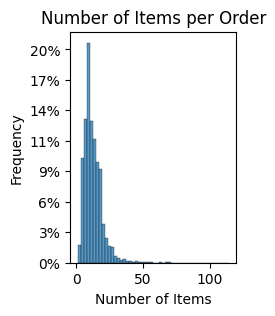

In [18]:
not_found = 0 
total_items_purchased = 0 
purchases_per_item = {} 
for order in orders["ordered_items"]: 
    for item in order: 
        if item not in inventory["variant_id"].values: 
            not_found += 1
        total_items_purchased += 1
        if item in purchases_per_item: 
            purchases_per_item[item] += 1 
        else: 
            purchases_per_item[item] = 1

print(f"{not_found/total_items_purchased * 100:.2f}% of ordered items not found in inventory.")

plt.figure(figsize=(15, 3)) 
plt.subplot(1, 6, 1)
sns.histplot(orders["num_items"], bins=50, kde=False) 
plt.title("Number of Items per Order") 
plt.xlabel("Number of Items") 
plt.ylabel("Frequency") 
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format((y / orders.shape[0]) * 100)))



# Summary statistics 
less_than_20 = orders[orders['num_items'] < 20].shape[0] 
print(f"Orders with less than 20 items: {less_than_20} ({(less_than_20 / orders.shape[0]) * 100:.2f}%)")

between_5_and_15 = orders[(orders['num_items'] >= 5) & (orders['num_items'] <= 15)].shape[0] 
print(f"Orders with 5 to 15 items: {between_5_and_15} ({(between_5_and_15 / orders.shape[0]) * 100:.2f}%)")

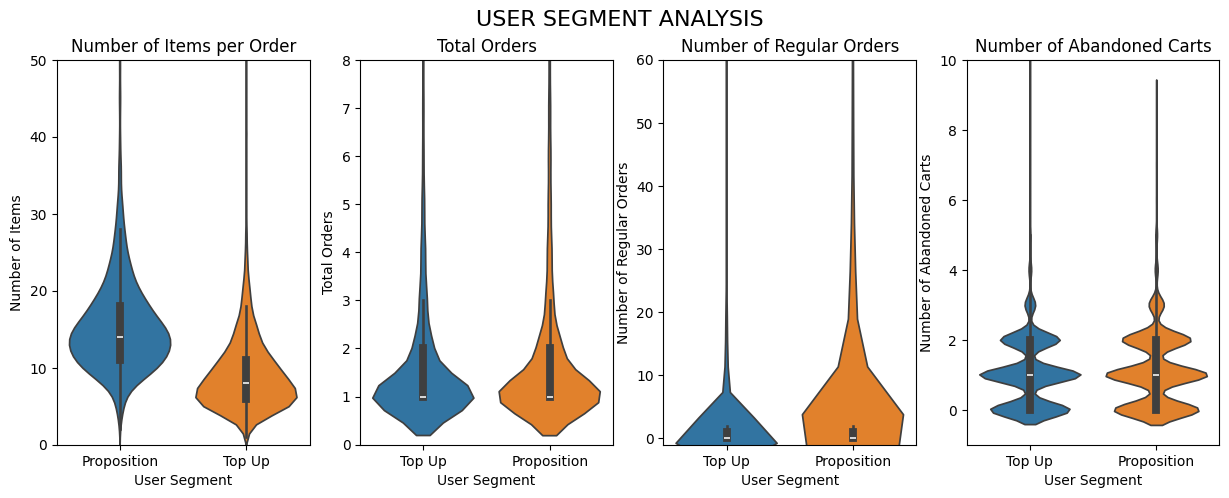

In [63]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
sns.violinplot(x='user_segment', y='num_items', data=orders, hue='user_segment')
plt.title("Number of Items per Order")
plt.xlabel("User Segment")
plt.ylabel("Number of Items")
plt.ylim(0, 50) 

plt.subplot(1, 4, 2)
sns.violinplot(x='user_segment', y='total_orders', data=users, hue='user_segment') 
plt.title("Total Orders")
plt.xlabel("User Segment")
plt.ylabel("Total Orders")
plt.ylim(0, 8)

plt.subplot(1, 4, 3)
sns.violinplot(x='user_segment', y='num_regulars', data=users, hue='user_segment') 
plt.title("Number of Regular Orders")
plt.xlabel("User Segment")
plt.ylabel("Number of Regular Orders")
plt.ylim(-1, 60)

plt.subplot(1, 4, 4)
sns.violinplot(x='user_segment', y='num_abandoned_carts', data=users, hue='user_segment') 
plt.title("Number of Abandoned Carts")
plt.xlabel("User Segment")
plt.ylabel("Number of Abandoned Carts")
plt.ylim(-1, 10)

plt.suptitle("USER SEGMENT ANALYSIS", fontsize=16)
plt.show()

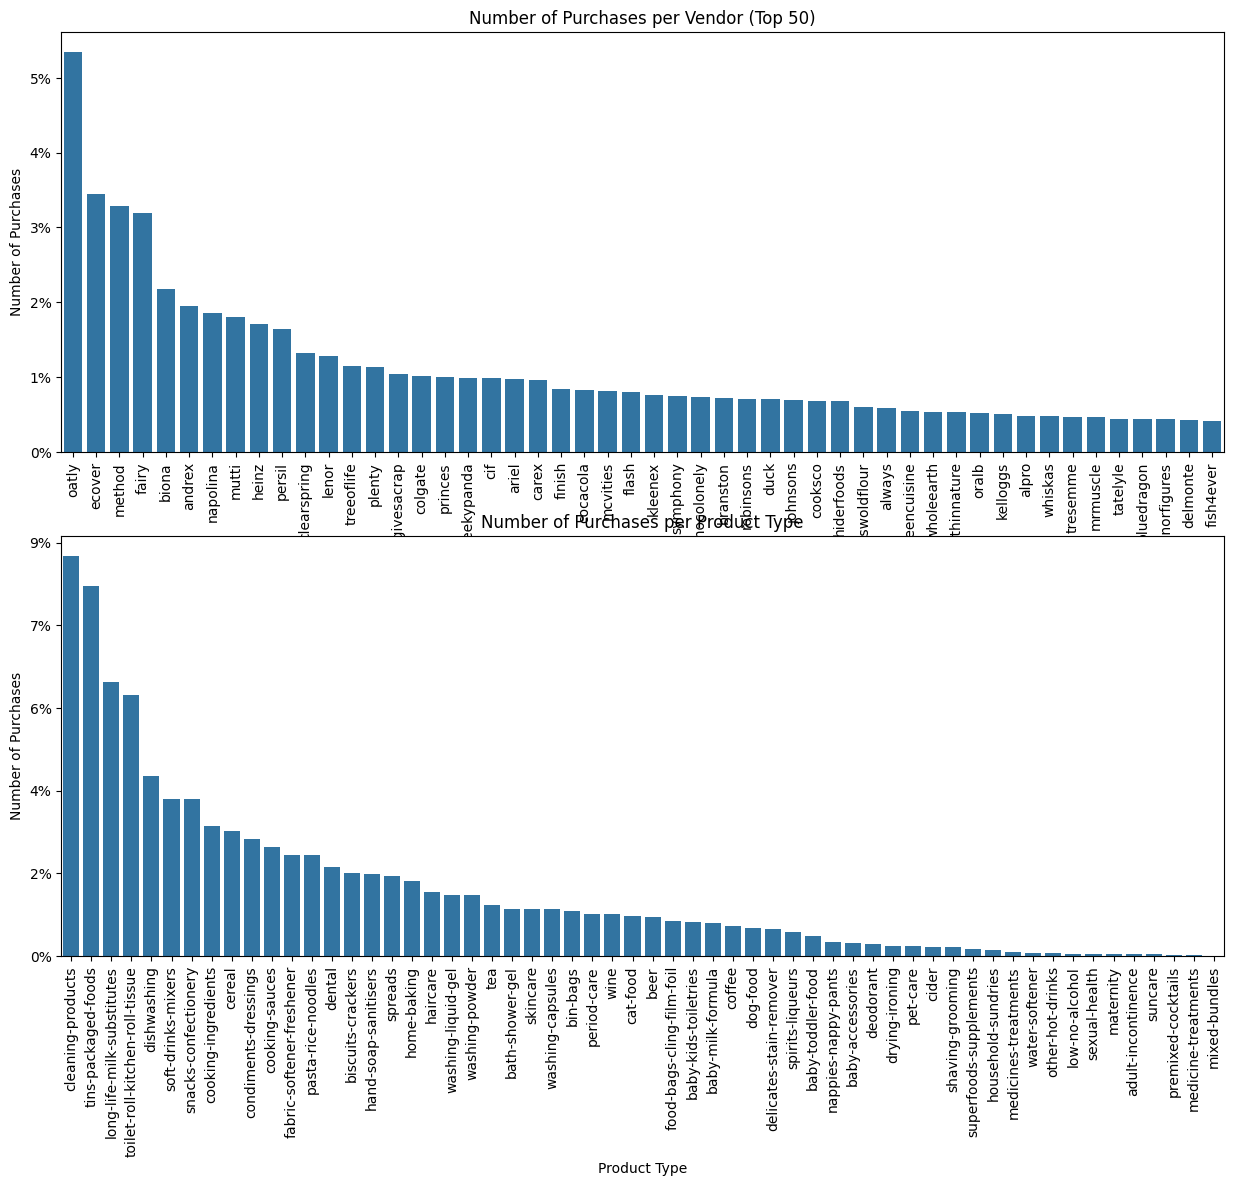

In [84]:
purchases_per_product_type = {} 
purchases_per_vendor = {} 
for order in orders["ordered_items"]: 
    for item in order: 
        item = int(item)
        if item in inventory["variant_id"].values: 
            product_type = inventory[inventory["variant_id"] == item]["product_type"].values[0]
            vendor = inventory[inventory["variant_id"] == item]["vendor"].values[0]
            if product_type in purchases_per_product_type: 
                purchases_per_product_type[product_type] += 1 
            else: 
                purchases_per_product_type[product_type] = 1
            if vendor in purchases_per_vendor:
                purchases_per_vendor[vendor] += 1
            else:
                purchases_per_vendor[vendor] = 1

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
sorted_vendors = sorted(purchases_per_vendor.items(), key=lambda x: x[1], reverse=True)[:50]
sns.barplot(x=[item[0] for item in sorted_vendors], y=[item[1] for item in sorted_vendors])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format((y / total_items_purchased) * 100)))
plt.xticks(rotation=90)
plt.title("Number of Purchases per Vendor (Top 50)")
plt.xlabel("Vendor")
plt.ylabel("Number of Purchases")

plt.subplot(2, 1, 2)
sorted_items = sorted(purchases_per_product_type.items(), key=lambda x: x[1], reverse=True)
sns.barplot(x=[item[0] for item in sorted_items], y=[item[1] for item in sorted_items])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format((y / total_items_purchased) * 100)))
plt.xticks(rotation=90)
plt.title("Number of Purchases per Product Type")
plt.xlabel("Product Type")
plt.ylabel("Number of Purchases")
plt.show()

Day with most orders: 2022-01-21 00:00:00 with 199 orders.


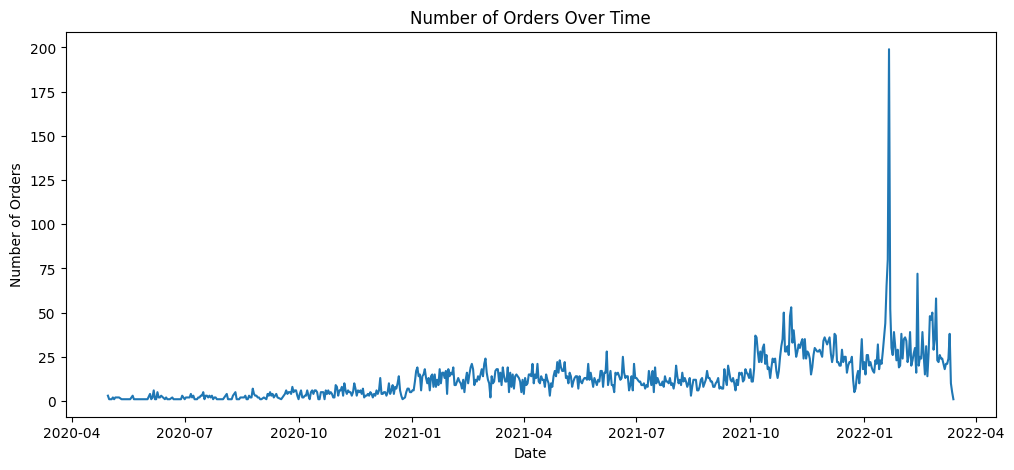

In [95]:
plt.figure(figsize=(12, 5))
plt.plot(orders['order_date'].value_counts().sort_index())
plt.title("Number of Orders Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
print(f"Day with most orders: {orders['order_date'].value_counts().idxmax()} with {orders['order_date'].value_counts().max()} orders.")

In [1]:
top_10_product_types = [item[0] for item in sorted(purchases_per_product_type.items(), key=lambda x: x[1], reverse=True)[:20]]
orders_expanded = orders.explode('ordered_items')
orders_expanded['ordered_items'] = orders_expanded['ordered_items'].astype(int)
orders_expanded = orders_expanded.merge(inventory[['variant_id', 'product_type']], left_on='ordered_items', right_on='variant_id', how='left')
orders_expanded_top_10 = orders_expanded[orders_expanded['product_type'].isin(top_10_product_types)]
plt.figure(figsize=(15, 5))
sns.countplot(data=orders_expanded_top_10, x='product_type', hue='time_of_day', order=top_10_product_types)
plt.title("Top 20 Product Types Purchased by Time of Day")
plt.xlabel("Product Type")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=90)
plt.legend(title='Time of Day')
plt.show()

NameError: name 'purchases_per_product_type' is not defined

In [10]:
orders.head() 

,id,user_id,created_at,order_date,user_order_seq,ordered_items,user_segment,num_items
0,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,"[33618849693828, 33618860179588, 3361887404045...",Proposition,14
1,2204707520644,bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...,2020-04-30 17:39:00,2020-04-30,1,"[33618835243140, 33618835964036, 3361886244058...",Proposition,25
2,2204838822020,329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...,2020-04-30 18:12:30,2020-04-30,1,"[33618891145348, 33618893570180, 3361889766618...",Top Up,15
3,2208967852164,f6451fce7b1c58d0effbe37fcb4e67b718193562766470...,2020-05-01 19:44:11,2020-05-01,1,"[33618830196868, 33618846580868, 3361891234624...",Proposition,10
4,2215889436804,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,2020-05-03 21:56:14,2020-05-03,1,"[33667166699652, 33667166699652, 3366717122163...",Proposition,10


In [9]:
inventory.head() 

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


In [51]:
users.head() 

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets,total_orders,num_regulars,num_abandoned_carts
2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,<NA>,<NA>,<NA>,<NA>,<NA>,1,0,0
1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,<NA>,<NA>,<NA>,<NA>,<NA>,1,0,1
1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,<NA>,<NA>,<NA>,<NA>,<NA>,1,0,0
675,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,<NA>,<NA>,<NA>,<NA>,<NA>,10,0,3
4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,<NA>,<NA>,<NA>,<NA>,<NA>,1,0,1


In [12]:
regulars.head() 

,user_id,variant_id,created_at,user_segment
0,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03,Proposition
1,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35,Proposition
2,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03,Proposition
3,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35,Proposition
4,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11,Top Up


In [13]:
abandoned_carts.head()

,id,user_id,created_at,variant_id,user_segment
0,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,"[33826459287684, 33826457616516, 3366719212762...",Proposition
1,20352449839236,9d6187545c005d39e44d0456d87790db18611d7c7379bd...,2021-06-27 05:24:13,"[34415988179076, 34037940158596, 3450282236326...",Top Up
2,20478401413252,e83fb0273d70c37a2968fee107113698fd4f389c442c0b...,2021-07-18 08:23:49,"[34543001337988, 34037939372164, 3411360609088...",Proposition
3,20481783103620,10c42e10e530284b7c7c50f3a23a98726d5747b8128084...,2021-07-18 21:29:36,"[33667268116612, 34037940224132, 3443605520397...",Proposition
4,20485321687172,d9989439524b3f6fc4f41686d043f315fb408b954d6153...,2021-07-19 12:17:05,"[33667268083844, 34284950454404, 33973246886020]",Top Up
